## Objective
Build up to an architecture that can predict digits with 99.4% or higher accuracy (on test set) in 3 stages.

This notebook refers to the **2nd of the 3 stages**, where the model architecture is refined to meet the specification of the task (i.e. the number of model parameters should be $\le 8000$). Further add _Dropout_ and _BatchNormalization_ to the network to reduce overfitting.

<br>

---

**Target**
- Refine the model architecture to meet the specifications
    - Parameters should be $\le 8000$
    - Use _Dropout_ of $0.05$
- Prevent fluctuations in the test accuracy
    - Using _BatchNormalization_ might help stabalize
- Reduce overfitting (i.e. training and test/validation accuracy should be vary proportionally)

**Results**
- Best Training Accuracy: _99.02_ (Iteration 14)
- Best Test Accuracy: _99.30_ (Iteration 12)
- Model Parameters: _7,940_

**Analysis**
- The number of model parameters required has been reduced substantially, which would reduce the training time.
- It no longer overfits (rather its a bit underfit)
- Perhaps using a higher learning rate with a LR scheduler should help the model learn better with additional augmentation methods incorporated as well (refer to Stage 3)

---

## Imports

In [1]:
# PyTorch, everything from PyTorch can be referred with this
import torch

# Import the neural network model seperately
import torch.nn as nn

# Contains functions that are required such as ReLu (Activation function)
import torch.nn.functional as F 

# Optimizers required to converge using Backpropogation
import torch.optim as optim

# Datasets are used to download and load the data
# used to train and validate
# Transforms can be used to define modifications and/or augmentations methods
# to be applied while passing the data
# Normalization can also be one of the compositions of transforms
import torchvision
from torchvision import datasets, transforms

# Dataset abstract class using which custom dataset classes can be created
# DataLoader to create batches and to shuffle the data
from torch.utils.data import Dataset, DataLoader

# Visualize the images
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid # ImageGrid to form a grid of images

# Utils
import cv2
import numpy as np
import seaborn as sns
from collections import OrderedDict

In [2]:
# Disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Create a custom dataset class
Define a class a that loads and takes the images from MNIST to use as input along with the actual label of the handwritten digit which constitutes the required output

In [3]:
class MNISTDataset (Dataset):
    ''' Extending the Dataset class to provide customized inputs and modified 
    outputs for training '''

    def __init__(self, mode='training', additional_transforms=None):
        ''' Get/Download the data (MNIST) and setup up other configurations
        required to get the data
        
        Parameters:
            mode - Indicates either 'training' or 'validation'
            transforms - A list of additional transformations to be added while training
                            By default Normalized the dataset
        '''

        # Start by initializing the base class
        super().__init__()

        # Save the mode
        # Check if the mode is valid
        assert mode in ['training', 'validation'], \
            '"mode" should be either "training" or "validation"'
        self.mode = mode

        # Seed the random generator to results that are reproduceable
        # Remove during production
        torch.manual_seed (1)

        # Define the transformations
        #   First convert into a tensor and then normalization
        #   Values for normalization where got from 
        #   https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457

        # Define a list of transforms to chain together            
        # Both the train and validation transforms are the same, but might decide 
        # to update with some data augmentation methods for train later
        # so keeping it seperate
        self.transforms = [
            transforms.ToTensor (), 
            transforms.Normalize((0.1307,), (0.3081,))]

        # Get MNIST data
        if self.mode == 'training':        

            # Chain the transforms
            if additional_transforms:
                self.transforms = self.transforms+additional_transforms 
        
            # Download the training set and store it at the root directory
            self.data = datasets.MNIST (
                root='./data/train/',
                train=True,
                download=True,
                transform=transforms.Compose (self.transforms))
            
        elif self.mode == 'validation':

            # Get the validation set
            self.data = datasets.MNIST (
                root='./data/val/',
                train=False,
                download=True,
                transform=transforms.Compose (self.transforms))
        

    def __len__(self):
        ''' Get the total size of the dataset '''
        return len (self.data)


    def __getitem__(self, index):
        ''' Used to get the index-th item from the dataset 
        
        Parameters:
            index - Element value to retrieve from the data
        '''

        # Check if the within the bounds of the data
        assert index < len (self.data), 'The index value is out-of-bound'

        # Index into the data to get the image and the corresponding label
        img, label = self.data [index]

        # Return the training set and the corresponding label
        return img, label

### Load the data
Define the data loaders for train and test with $batch\_size = 128$.

In [4]:
# Seed the random generator used by PyTorch
# so that the results are reproduceable
torch.manual_seed(1)

# Define the batch size to be used
# i.e. the number of images to be used per batch
batch_size = 128

# Set it to use GPU if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Define a dataloader 
# Set the batch_size and shuffle to select
# random images for every batch and epoch

# Parameters to be used while loading the data
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Additional transformations/augmentations are not added to this
# version, will add that in the next steps
train_loader = DataLoader (
    MNISTDataset (
        mode='training'),
        #additional_transforms=[
        #    RandomErosion ((2, 2)),
        #    RandomDilation ((2, 2))]),
    batch_size=batch_size,
    shuffle=True,
    **kwargs)

test_loader = DataLoader (
    MNISTDataset (mode='validation'),
    batch_size=batch_size,
    shuffle=True,
    **kwargs)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/train/MNIST/raw/train-images-idx3-ubyte.gz to ./data/train/MNIST/raw




Extracting ./data/train/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/train/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/train/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/train/MNIST/raw

Processing...
Done!
Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/val/MNIST/raw/train-images-idx3-ubyte.gz to ./data/val/MNIST/raw




Extracting ./data/val/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/val/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/val/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/val/MNIST/raw




Extracting ./data/val/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/val/MNIST/raw

Processing...
Done!


In [5]:
print (f'No. of training batches: {len (train_loader)}\nNo. of test batches: {len (test_loader)}')

No. of training batches: 469
No. of test batches: 79


## Define the network architecture

In [40]:
class MNISTNet(nn.Module):
    ''' Define a class initializing the layers constituting the required 
    CNN Architecture and the code for forward pass
    Note: The class extends to the nn.Module, which is a base class for 
    Neural Network modules in PyTorch https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    '''

    def __init__(self, drop_perc=0.05):
        ''' Define the layers that constitute the network and
        initialize the base class '''

        # Start by initializing the base class
        super().__init__()

        # Store the dropout percentage
        self.drop_perc = drop_perc
    
        # Define the layers that make up the network
        # i.e. the Network Architecture
        # nn.Conv2d - Used to perform 2-dimensional convolution using the defined size of the kernel
        # nn.MaxPool2d - 2d MaxPooling Layer of the defined size

        # MNIST contains images of size 28x28
        # Since the images are padded, the resultant images after convolution
        # would have the same size
        
        # Input Block
        self.input_block = nn.Sequential (
            OrderedDict ([
                ('input_block_conv1', nn.Conv2d (1, 16, 3, padding=False, bias=False)),
                ('input_block_bn', nn.BatchNorm2d (16)),
                ('input_block_relu', nn.ReLU ()),
                ('input_block_dropout', nn.Dropout (self.drop_perc)), # Out: 26
                ('input_block_one', nn.Conv2d (16, 8, 1, padding=False, bias=False)) # Out: 26
            ])
        )

        # First Convolution Block
        self.block1 = nn.Sequential (
            OrderedDict ([
                ('block1_conv1', nn.Conv2d (8, 8, 3, padding=False, bias=False)),
                ('block1_bn1', nn.BatchNorm2d (8)),
                ('block1_relu1', nn.ReLU ()),
                ('block1_dropout1', nn.Dropout (self.drop_perc)), # Out: 24

                ('block1_conv2', nn.Conv2d (8, 16, 3, padding=True, bias=False)),
                ('block1_bn2', nn.BatchNorm2d (16)),
                ('block1_relu2', nn.ReLU ()),
                ('block1_dropout2', nn.Dropout (self.drop_perc)), # Out: 24    
            ])    
        )

        # Pooling Layer
        self.pool_block1 = nn.Sequential (
            OrderedDict ([
                ('pool_b1_mp', nn.MaxPool2d (2, 2)), # Out: 12
                ('pool_b1_one', nn.Conv2d (16, 8, 1, padding=False, bias=False)) # Out: 12
            ])
        )

        # Second Convolution Block
        self.block2 = nn.Sequential (
            OrderedDict ([
                ('block2_conv1', nn.Conv2d (8, 8, 3, padding=False, bias=False)),
                ('block2_bn1', nn.BatchNorm2d (8)),
                ('block2_relu1', nn.ReLU ()),
                ('block2_dropout1', nn.Dropout (self.drop_perc)), # Out: 10

                ('block2_conv2', nn.Conv2d (8, 14, 3, padding=True, bias=False)),
                ('block2_bn2', nn.BatchNorm2d (14)),
                ('block2_relu2', nn.ReLU ()),
                ('block2_dropout2', nn.Dropout (self.drop_perc)), # Out: 10     
                ('block2_one', nn.Conv2d (14, 8, 1, padding=False, bias=False)) # Out: 10
            ])    
        )

        # Last Convolution Block
        self.block3 = nn.Sequential (
            OrderedDict ([
                ('block3_conv1', nn.Conv2d (8, 16, 3, padding=False, bias=False)),
                ('block3_bn1', nn.BatchNorm2d (16)),
                ('block3_relu1', nn.ReLU ()),
                ('block3_dropout1', nn.Dropout (self.drop_perc)), # Out: 8

                ('block3_conv2', nn.Conv2d (16, 18, 3, padding=False, bias=False)),
                ('block3_bn2', nn.BatchNorm2d (18)),
                ('block3_relu2', nn.ReLU ()),
                ('block3_dropout2', nn.Dropout (self.drop_perc)), # Out: 6   
            ])
        )

        # Gap & Final layer with the predictions
        self.prediction = nn.Sequential (
            OrderedDict ([
                ('gap', nn.AvgPool2d (kernel_size=6)),
                ('pred_layer', nn.Conv2d (18, 10, 1, padding=False, bias=False))
            ])
        )

        
    def forward(self, x):
        ''' Define the forward pass
        Each convolution layer is activated using ReLU to add non-linearity
        '''
        # Start with the input block to convert the grayscale (no. of channels = 1)
        # to something higher
        x = self.input_block (x)

        # Convolution layer followed by ReLU Activation, followed by Batch Normalization
        # followed by Dropout and then finally a pooling layer
        # Block 1
        x = self.block1 (x)

        # Pooling layer
        x = self.pool_block1 (x)

        # Block 2
        x = self.block2 (x)

        # Block 3
        x = self.block3 (x)

        # The final layer shouldn't be passed through ReLU, but should be retained
        # Using Global Average Pooling & and 1x1 to reduce the final output size
        x = self.prediction (x)

        # Reshape to fit the output and return
        x = x.view (-1, 10)
        return F.log_softmax (x)

In [41]:
# To display an overview/summary of the network
# Is also useful to validate whether the structure of the network is 
# correct, i.e. the input channels and the output channels and its flow
!pip install torchsummary
from torchsummary import summary

# Set it to use GPU if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Define the dropout_percentage
dropout_percentage = 0.05

# Create a model object
model = MNISTNet (drop_perc=dropout_percentage).to (device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5            [-1, 8, 26, 26]             128
            Conv2d-6            [-1, 8, 24, 24]             576
       BatchNorm2d-7            [-1, 8, 24, 24]              16
              ReLU-8            [-1, 8, 24, 24]               0
           Dropout-9            [-1, 8, 24, 24]               0
           Conv2d-10           [-1, 16, 24, 24]           1,152
      BatchNorm2d-11           [-1, 16, 24, 24]              32
             ReLU-12           [-1, 16, 24, 24]               0
          Dropout-13           [-1, 16, 24, 24]               0
        MaxPool2d-14           [-1, 16,

## Train and Validate

In [42]:
# TQDM is just awesome... provides a progress status bar as the training 
# (or any operation) proceeds
from tqdm import tqdm


def train(model, device, train_loader, optimizer, epoch):
    ''' Define the training steps '''

    # Set the model to training mode
    model.train()
    
    # Initialize the counters
    correct = 0
    processed = 0

    # Initialize the progress bar
    pbar = tqdm(train_loader)

    # Start iterating through the training data
    for batch_idx, (data, target) in enumerate(pbar):
        # Start by converting the data to the required type 
        # (PyTorch Cuda Tensor while using GPU)
        data, target = data.to(device), target.to(device)

        # Discard/reset the gradients from the last iteration
        optimizer.zero_grad()

        # Get the predictions for the given data
        output = model(data)

        # Compute the negative loss likelihood of the predictions vs the actuals
        # and propogate the loss backwards (back propogation)
        loss = F.nll_loss(output, target)
        loss.backward()

        # Use the optimizer to take a step in the -ve of the gradient direction
        # by the amount equal to the gradient magnitude times the learning rate 
        optimizer.step()
        
        # Get the index of the prediction
        # i.e. the output is one-hot encoded, so get the argument with the max
        # log probability
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

        # Get a count of the correct preditcions
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        # Update the no of records processed
        processed += len (data)

        # Update the progress bar
        pbar.set_description(
            desc=f'Loss={loss.item():.4f}; '+\
                 f'Accuracy={correct*100/processed:.2f}; '+\
                 f'Learning Rate={optimizer.param_groups[0]["lr"]:.4f}')
        
        # Store the training accuracy & loss
        training_accuracy.append (correct*100/processed)
        training_losses.append (loss)


def test(model, device, test_loader):
    ''' Validate the trained model on a hold-out set '''

    # Set the model to evalution mode
    model.eval()
    
    # Initialize the losses
    # and the no of correct predictions to 0
    test_loss = 0
    correct = 0

    # Disable the gradient computations
    # While evaulating only forward pass is used and the backward pass
    # along with the gradient (likewise the gradient update) isn't required
    with torch.no_grad():
        # Iterate over the test/validation set
        for data, target in test_loader:
            # Converting the data to the required type 
            # (PyTorch Cuda Tensor while using GPU)
            data, target = data.to(device), target.to(device)

            # Get the predictions
            output = model(data)

            # Compute the loss against the target
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            # Get the index of the prediction
            # i.e. the output is one-hot encoded, so get the argument with the max
            # log probability
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            # Get a count of the correct preditcions
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Compute the final loss on the test/validation data
    test_loss /= len(test_loader.dataset)

    # Display the results
    print('\nTest set: Loss={:.4f}; Accuracy={}/{} ({:.2f}%)\n\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # Store the training accuracy & loss
    test_accuracy.append (correct*100/len(test_loader.dataset))
    test_losses.append (test_loss)

In [43]:
# Initialize the model instance
model = MNISTNet().to(device)

# Define an optimizer to use to perform gradient descent
# Various optimizers are suitable for different usecase, which help
# reach the global optimal (i.e. a model with least errors/loss) quickly
# In this case, Stochastic Gradient Descent (SGD) is used with momentum of 0.9
# and the learning rate (alpha) set to 0.01 
optimizer = optim.SGD (model.parameters(), lr=0.01, momentum=0.9)

# Train the model for n epochs
epochs = 14

# Store the training accuracy and losses
training_accuracy = []
training_losses = []

# Store the test accuracy and losses
test_accuracy = []
test_losses = []

for epoch in range(0, epochs):
    print (f'Iteration {epoch+1}')
    # Initiate training phase
    train(model, device, train_loader, optimizer, epoch)

    # Validate the results on the test/validation set
    test(model, device, test_loader)

print (f'Best Model had a Training Accuracy of {np.max (training_accuracy):.2f}', 
        f'& a Test Accuracy of {np.max (test_accuracy):.2f}')

  0%|          | 0/469 [00:00<?, ?it/s]

Iteration 1


Loss=0.1710; Accuracy=79.09; Learning Rate=0.0100: 100%|██████████| 469/469 [00:12<00:00, 36.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.1362; Accuracy=9648/10000 (96.48%)


Iteration 2


Loss=0.0646; Accuracy=97.10; Learning Rate=0.0100: 100%|██████████| 469/469 [00:13<00:00, 35.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0772; Accuracy=9802/10000 (98.02%)


Iteration 3


Loss=0.0618; Accuracy=97.91; Learning Rate=0.0100: 100%|██████████| 469/469 [00:12<00:00, 36.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0560; Accuracy=9832/10000 (98.32%)


Iteration 4


Loss=0.0206; Accuracy=98.30; Learning Rate=0.0100: 100%|██████████| 469/469 [00:13<00:00, 36.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0551; Accuracy=9848/10000 (98.48%)


Iteration 5


Loss=0.0459; Accuracy=98.44; Learning Rate=0.0100: 100%|██████████| 469/469 [00:12<00:00, 36.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0394; Accuracy=9892/10000 (98.92%)


Iteration 6


Loss=0.0179; Accuracy=98.57; Learning Rate=0.0100: 100%|██████████| 469/469 [00:13<00:00, 35.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0385; Accuracy=9883/10000 (98.83%)


Iteration 7


Loss=0.0387; Accuracy=98.67; Learning Rate=0.0100: 100%|██████████| 469/469 [00:13<00:00, 35.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0325; Accuracy=9902/10000 (99.02%)


Iteration 8


Loss=0.0100; Accuracy=98.70; Learning Rate=0.0100: 100%|██████████| 469/469 [00:13<00:00, 35.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0390; Accuracy=9885/10000 (98.85%)


Iteration 9


Loss=0.0178; Accuracy=98.82; Learning Rate=0.0100: 100%|██████████| 469/469 [00:13<00:00, 36.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0315; Accuracy=9908/10000 (99.08%)


Iteration 10


Loss=0.0446; Accuracy=98.81; Learning Rate=0.0100: 100%|██████████| 469/469 [00:13<00:00, 36.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0275; Accuracy=9914/10000 (99.14%)


Iteration 11


Loss=0.0226; Accuracy=98.93; Learning Rate=0.0100: 100%|██████████| 469/469 [00:13<00:00, 34.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0259; Accuracy=9918/10000 (99.18%)


Iteration 12


Loss=0.0230; Accuracy=99.01; Learning Rate=0.0100: 100%|██████████| 469/469 [00:13<00:00, 35.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0245; Accuracy=9930/10000 (99.30%)


Iteration 13


Loss=0.0481; Accuracy=99.00; Learning Rate=0.0100: 100%|██████████| 469/469 [00:13<00:00, 35.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0258; Accuracy=9913/10000 (99.13%)


Iteration 14


Loss=0.0146; Accuracy=99.02; Learning Rate=0.0100: 100%|██████████| 469/469 [00:12<00:00, 36.53it/s]



Test set: Loss=0.0238; Accuracy=9923/10000 (99.23%)


Best Model had a Training Accuracy of 100.00 & a Test Accuracy of 99.30


### Plot the accuracy and loss

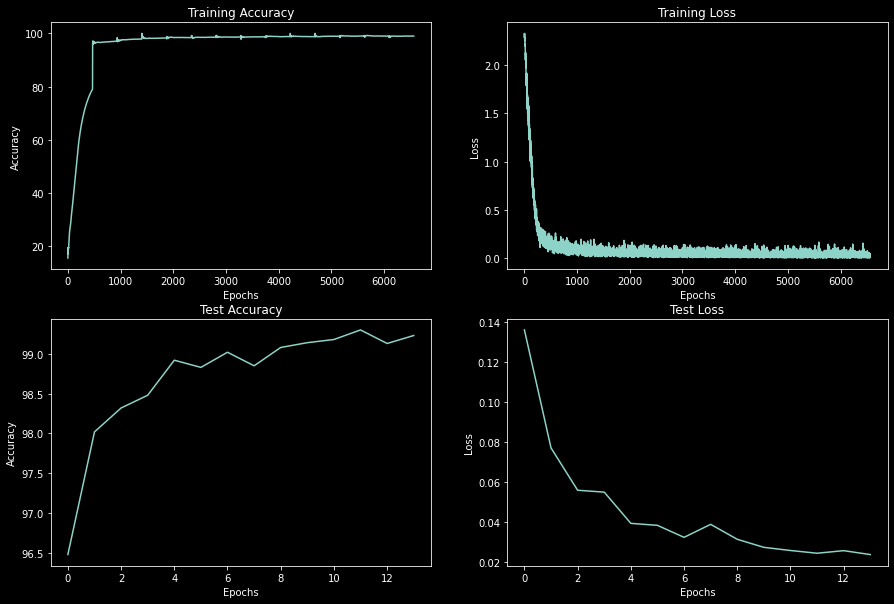

In [44]:
plt.style.use ('dark_background') # Dark mode rocks!!!

# Define the size of the figure
plt.figure (figsize=(15, 10))

# Plot the Training Accuracy
plt.subplot (221)
plt.plot (training_accuracy)
plt.title ('Training Accuracy')
plt.ylabel ('Accuracy'); plt.xlabel ('Epochs');

# Losses during training
plt.subplot (222)
plt.plot (training_losses)
plt.title ('Training Loss')
plt.ylabel ('Loss'); plt.xlabel ('Epochs');

# Test Accuracy at each epoch
plt.subplot (223)
plt.plot (test_accuracy)
plt.title ('Test Accuracy')
plt.ylabel ('Accuracy'); plt.xlabel ('Epochs');

# Test Losses at each epoch
plt.subplot (224)
plt.plot (test_losses)
plt.title ('Test Loss')
plt.ylabel ('Loss'); plt.xlabel ('Epochs');

- Training and Test accuracies are more or less similar
- The traning accuracy is at best at 99.0% (for the text accuracy of 99.21%)
    - Tweaking the learning rate might speed up learning